# 예측 모델 구성 및 SR_01 구현

## 학습 데이터셋 구성

In [1]:
import mysql.connector


remote = mysql.connector.connect (
    host = "jinhyuk2db.c94oygiiukcg.ap-northeast-2.rds.amazonaws.com",
    port = 3306,
    user = "root",
    password = "jinhyuk2dacibul",
    database = "project1"
)

limit = 1

cursor = remote.cursor(buffered=True)
cursor.execute(f"""SELECT w.weather_date, w.weather_hour, r.rental_station_id, r.rental_count,
                            c.weekday_int, c.weekday_name, c.is_holiday,
                            temp, rain, humid, wind, sunlight_direct, radiation_total, snow
                    FROM weather_hourly w, calendar c,
                        (SELECT *
                        FROM rental_hourly_station r,
                            (SELECT rental_station_id stations, AVG(rental_count)
                            FROM rental_daily_station
                            GROUP BY rental_station_id
                            HAVING AVG(rental_count)
                            ORDER By AVG(rental_count) desc
                            LIMIT {limit}) d
                        WHERE r.rental_station_id = d.stations) r
                    WHERE (r.rental_date = w.weather_date)
                        AND (r.rental_date = c.rental_date)
                        AND (r.rental_hour = w.weather_hour)""")

result = cursor.fetchall()

remote.close()

In [2]:
import pandas as pd

df = pd.DataFrame(result, columns = ['일자', '시간(시)', '대여소ID', '대여량', '요일ID', '요일', '휴일',
                                     '기온(℃)', '강수량(mm)', '습도(%rh)', '풍속(m/s)', '일조(hr)', '일사(MJ/m2)', '적설(cm)'])
df

,일자,시간(시),대여소ID,대여량,요일ID,요일,휴일,기온(℃),강수량(mm),습도(%rh),풍속(m/s),일조(hr),일사(MJ/m2),적설(cm)
0,2024-01-01,0,ST-2031,7,0,Monday,1,0.6,0.0,97.0,1.9,0.0,0.00,2.4
1,2024-01-01,1,ST-2031,4,0,Monday,1,0.5,0.0,97.0,2.2,0.0,0.00,2.4
2,2024-01-01,5,ST-2031,5,0,Monday,1,0.3,0.0,99.0,1.2,0.0,0.00,2.4
3,2024-01-01,6,ST-2031,1,0,Monday,1,0.5,0.0,99.0,2.0,0.0,0.00,2.4
4,2024-01-01,7,ST-2031,3,0,Monday,1,0.4,0.0,98.0,2.1,0.0,0.00,2.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8041,2024-12-31,3,ST-2031,1,1,Tuesday,0,2.0,0.0,53.0,3.2,0.0,0.00,0.0
8042,2024-12-31,5,ST-2031,2,1,Tuesday,0,0.2,0.0,49.0,2.7,0.0,0.00,0.0
8043,2024-12-31,17,ST-2031,40,1,Tuesday,0,2.5,0.0,37.0,3.4,1.0,0.42,0.0
8044,2024-12-31,21,ST-2031,15,1,Tuesday,0,-0.7,0.0,51.0,1.0,0.0,0.00,0.0


## 모델 학습 및 평가

전체 테스트셋 기준 성능
RMSE : 8.79
MAE  : 5.65
MAPE : 57.05%
R²   : 0.860

 실질적 수요 구간 (대여량 > 10) 기준 성능
Filtered RMSE : 9.60
Filtered MAE  : 6.66
Filtered MAPE : 23.24%
Filtered R²   : 0.835


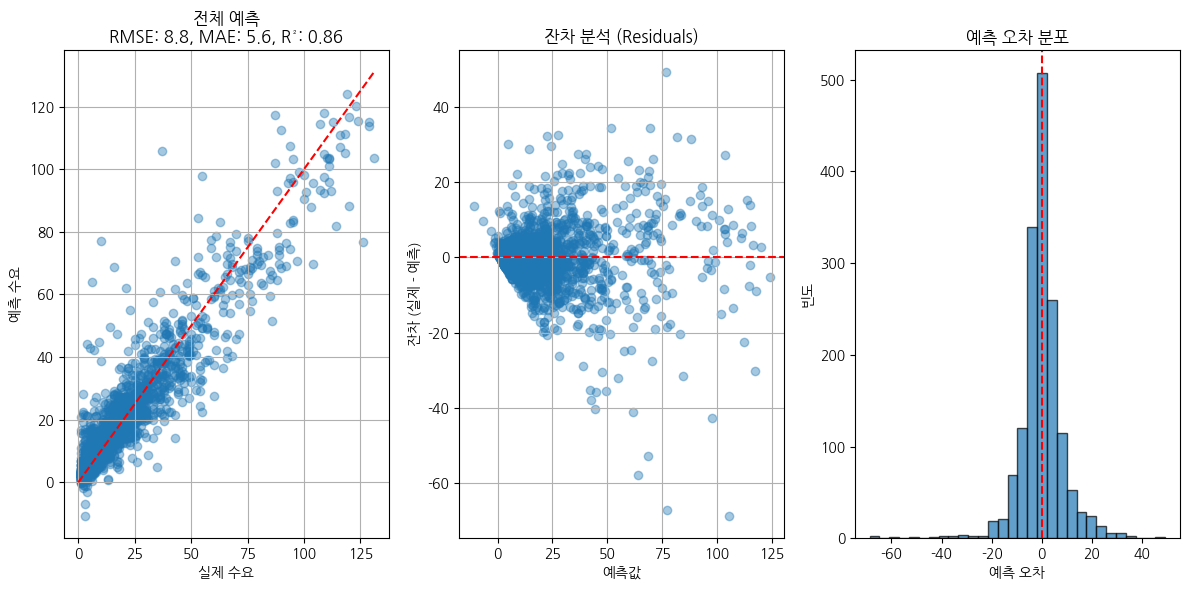

In [3]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import koreanize_matplotlib

# 데이터 전처리
df['datetime'] = pd.to_datetime(df['일자']) + pd.to_timedelta(df['시간(시)'], unit='h')
df = df.sort_values(['대여소ID', 'datetime'])

# 순환적 시간 feature 생성
df['hour_sin'] = np.sin(2 * np.pi * df['시간(시)'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['시간(시)'] / 24)
df['dow_sin'] = np.sin(2 * np.pi * df['요일ID'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['요일ID'] / 7)

# 주말 여부
df['is_weekend'] = df['요일ID'] >= 5

# lag feature (24시간 전 수요)
df['lag_1day'] = df.groupby('대여소ID')['대여량'].shift(24)

# 결측 제거
df_model = df.dropna(subset=['lag_1day'])

# feature 목록 정의
feature_cols = [
    'hour_sin', 'hour_cos',
    'dow_sin', 'dow_cos',
    'is_weekend', '휴일',
    '기온(℃)', '강수량(mm)', '습도(%rh)', '풍속(m/s)', '일사(MJ/m2)',
    'lag_1day'
]

X = df_model[feature_cols]
y = df_model['대여량']

# train/test 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 학습
model = XGBRegressor(n_estimators=300, max_depth=6, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# MAPE 함수 정의
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true > 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# 전체 지표 계산
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 실질 수요 구간 필터링 (대여량 > 10)
mask = y_test > 10
y_test_f = y_test[mask]
y_pred_f = y_pred[mask]

# 실질 수요 지표 계산
mse_f = mean_squared_error(y_test_f, y_pred_f)
rmse_f = mse_f ** 0.5
mae_f = mean_absolute_error(y_test_f, y_pred_f)
mape_f = mean_absolute_percentage_error(y_test_f, y_pred_f)
r2_f = r2_score(y_test_f, y_pred_f)

# 결과 출력
print("전체 테스트셋 기준 성능")
print(f"RMSE : {rmse:.2f}")
print(f"MAE  : {mae:.2f}")
print(f"MAPE : {mape:.2f}%")
print(f"R²   : {r2:.3f}")

print("\n 실질적 수요 구간 (대여량 > 10) 기준 성능")
print(f"Filtered RMSE : {rmse_f:.2f}")
print(f"Filtered MAE  : {mae_f:.2f}")
print(f"Filtered MAPE : {mape_f:.2f}%")
print(f"Filtered R²   : {r2_f:.3f}")

# 예측 오차 계산
residuals = y_test - y_pred
residuals_f = y_test_f - y_pred_f

# 시각화 (예측 vs 실제 + 잔차분석 + 히스토그램)
plt.figure(figsize=(12, 6))

# 1. 전체 테스트셋 예측 시각화
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--')
plt.xlabel("실제 수요")
plt.ylabel("예측 수요")
plt.title(f"전체 예측\nRMSE: {rmse:.1f}, MAE: {mae:.1f}, R²: {r2:.2f}")
plt.grid(True)

# 2. 잔차 vs 예측값
plt.subplot(1, 3, 2)
plt.scatter(y_pred, residuals, alpha=0.4)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("예측값")
plt.ylabel("잔차 (실제 - 예측)")
plt.title("잔차 분석 (Residuals)")
plt.grid(True)

# 3. 잔차 히스토그램
plt.subplot(1, 3, 3)
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(0, color='r', linestyle='--')
plt.title("예측 오차 분포")
plt.xlabel("예측 오차")
plt.ylabel("빈도")

plt.tight_layout()
plt.show()


## 날씨 API를 통해 날씨 데이터 실시간으로 가져오기

In [4]:
import ssl
import pandas as pd
from datetime import datetime, timedelta
import json
import requests

#---------------------------------가장 최신 발표 시간 얻는 함수-----------------------------------------
def get_latest_forecast_time():
    # 발표 시간 목록 (24시간 형식)
    forecast_times = ["0200", "0500", "0800", "1100", "1400", "1700", "2000", "2300"]

    # 현재 시간
    now = datetime.now()

    # 현재 날짜 문자열 (YYYYMMDD)
    current_date = now.strftime("%Y%m%d")

    # 현재 시간 문자열 (HHMM)
    current_time = now.strftime("%H%M")

    # 오늘 발표된 시간 중 현재 시간보다 이전인 것 찾기
    available_times = [t for t in forecast_times if t <= current_time]

    # 오늘 발표된 시간 중 가장 최근 시간
    if available_times:
        latest_time = max(available_times)
        return current_date, latest_time
    else:
        # 오늘 발표된 시간이 없는 경우 (현재 시간이 0200 이전)
        # 전날 마지막 발표 시간 사용
        yesterday = now - timedelta(days=1)
        yesterday_date = yesterday.strftime("%Y%m%d")
        return yesterday_date, forecast_times[-1]  # 2300

#-----------------------------------API 호출------------------------------------------

# 날씨를 알고 싶은 시간 입력
date, time = get_latest_forecast_time()
nx = '62' # 예보 지점 x좌표
ny = '123' # 예보 지점 y좌표
numOfRows = 1000

url = "http://apis.data.go.kr/1360000/VilageFcstInfoService_2.0"
url2 = "http://apis.data.go.kr/1360000/VilageFcstInfoService_2.0/getVilageFcst"

serviceKeyE = "vf5wY%2FHyYSFgTBL63CIUXrE9QpdzM4Dklyhr%2FV3E0Zj9D7wMZSeiBfcr%2B27XEebGhg1RZAjdvDk9Rp2bF8PMwg%3D%3D"
serviceKeyD = "vf5wY/HyYSFgTBL63CIUXrE9QpdzM4Dklyhr/V3E0Zj9D7wMZSeiBfcr+27XEebGhg1RZAjdvDk9Rp2bF8PMwg=="


params = {
    'ServiceKey': serviceKeyD,
    'pageNo': '1',
    'numOfRows': numOfRows,
    'dataType': 'JSON',
    'base_date': date,
    'base_time': time,
    'nx': nx,
    'ny': ny,
}

responses = requests.get(url2, params=params)
response = json.loads(responses.text)


#-----------------------------------API 결과물들 List 로 저장------------------------------------------

section = response['response']['body']['items']['item']
dates = []
times = []
cates = []
values =[]

for i, row in enumerate(section):
    dates.append(row['fcstDate'])
    times.append(row['fcstTime'][:-2])
    cates.append(row['category'])
    values.append(row['fcstValue'])

#-----------------------------------df_api 원본 그대로 일단 표 생성------------------------------------------

df_api = pd.DataFrame({'일자':dates,
                        '시간': times,
                        '종류':cates,
                        '값':values})
df_api

#-----------------------------------Pivot_api 로 구조 정리------------------------------------------
pivot_api = df_api.pivot(index=['일자','시간'], columns='종류', values='값')

date_list = []
time_list = []
temp_list = []
rain_list = []
humid_list = []
wind_list = []
sunlight_list = []
radiation_list = []
snow_list = []

for i, row in enumerate(pivot_api.values):

    rain = pivot_api['PCP'].iloc[i]
    if rain == "강수없음":
        rain = 0
    elif rain == "1mm 미만":
        rain = 1
    elif rain == "2.0mm":
        rain = 2
    elif rain == "3.0mm":
        rain = 3

    snow = pivot_api['SNO'].iloc[i]
    if snow == "적설없음":
        snow = 0

    sky = pivot_api['SKY'].iloc[i]
    if sky == '1':  # 맑음
        sunlight = 1.0
        radiation = 3.0
    elif sky == '3':  # 구름 많음
        sunlight = 0.6
        radiation = 1.5
    elif sky == '4':  # 흐림
        sunlight = 0.2
        radiation = 0.5
    else:
        sunlight = 0.4  # 기본값
        radiation = 1.0


    date_list.append(pivot_api.index[i][0])
    time_list.append(pivot_api.index[i][1])
    temp_list.append(pivot_api['TMP'].iloc[i])
    rain_list.append(rain)
    humid_list.append(pivot_api['REH'].iloc[i])
    wind_list.append(pivot_api['WSD'].iloc[i])
    sunlight_list.append(sunlight)
    radiation_list.append(radiation)
    snow_list.append(snow)

#-----------------------------------df_fsct - 머신러닝에 맞는 구조로 변환------------------------------------------

df_fcst = pd.DataFrame({'일자': date_list,
                        '시간(시)': time_list,
                        '기온(℃)': temp_list,
                        '강수량(mm)' : rain_list,
                        '습도(%rh)' : humid_list,
                        '풍속(m/s)' : wind_list,
                        '일조(hr)' : sunlight_list,
                        '일사(MJ/m2)': radiation_list,
                        '적설(cm)': snow_list})

df_fcst.head(72) # 72 시간 앞

,일자,시간(시),기온(℃),강수량(mm),습도(%rh),풍속(m/s),일조(hr),일사(MJ/m2),적설(cm)
0,20250406,15,15,0,30,4.3,1.0,3.0,0
1,20250406,16,15,0,25,4.3,1.0,3.0,0
2,20250406,17,14,0,35,4.2,1.0,3.0,0
3,20250406,18,13,0,40,3.4,1.0,3.0,0
4,20250406,19,11,0,50,1.8,1.0,3.0,0
...,...,...,...,...,...,...,...,...,...
61,20250409,12,18,0,60,1,0.2,0.5,0
62,20250409,15,18,0,50,1,0.6,1.5,0
63,20250409,18,15,0,75,1,0.2,0.5,0
64,20250409,21,13,0,80,1,0.6,1.5,0


## calendar 생성

In [5]:
import pandas as pd
import holidays

def generate_calendar(start='2025-01-01', end='2025-12-31'):
    kr_holidays = holidays.KR(years=[2025])
    dates = pd.date_range(start=start, end=end)
    calendar = pd.DataFrame({
        'rental_date': dates,
        'weekday_int': dates.weekday,  # 월:0 ~ 일:6
        'weekday_name': dates.strftime('%A'),
        'is_holiday': [int(d in kr_holidays) for d in dates]
    })
    calendar['rental_date'] = calendar['rental_date'].dt.strftime('%Y%m%d')
    return calendar

calendar_df = generate_calendar()
print(calendar_df.head())


  rental_date  weekday_int weekday_name  is_holiday
0    20250101            2    Wednesday           1
1    20250102            3     Thursday           0
2    20250103            4       Friday           0
3    20250104            5     Saturday           0
4    20250105            6       Sunday           0


## 기능 구현

In [6]:
import pandas as pd
import numpy as np
from datetime import datetime
from xgboost import XGBRegressor

# 입력 처리
def get_target_datetime():
    today = datetime.today()

    # 사용자 입력
    day_input = input("날짜를 입력하세요 (오늘/내일/모레): ").strip()
    hour_input = input("예측할 시간을 입력하세요 (0~23 사이 정수): ").strip()

    day_map = {'오늘': 0, '내일': 1, '모레': 2}
    if day_input not in day_map or not hour_input.isdigit():
        raise ValueError("입력이 올바르지 않습니다.")

    delta_days = day_map[day_input]
    target_date = (today + pd.Timedelta(days=delta_days)).strftime('%Y%m%d')
    target_hour = int(hour_input)

    return target_date, target_hour

def build_feature_row(target_date, target_hour, calendar_df, forecast_df, station_id, lag_1day):
    # rental_date 형식 통일
    if calendar_df['rental_date'].dtype != object:
        calendar_df['rental_date'] = pd.to_datetime(calendar_df['rental_date']).dt.strftime('%Y%m%d')

    cal_rows = calendar_df[calendar_df['rental_date'] == target_date]
    if cal_rows.empty:
        raise ValueError(f"calendar_df에 '{target_date}' 해당 데이터가 없습니다.")

    cal_row = cal_rows.iloc[0]
    weekday_int = cal_row['weekday_int']
    is_holiday = cal_row['is_holiday']

    # forecast 정보
    fcst_row = forecast_df[
        (forecast_df['일자'] == target_date) &
        (forecast_df['시간(시)'].astype(int) == target_hour)
    ]

    if fcst_row.empty:
        raise ValueError(f"forecast_df에 '{target_date} {target_hour}시' 데이터가 없습니다.")

    fcst_row = fcst_row.iloc[0]

    # feature 계산
    feature = {
        'hour_sin': np.sin(2 * np.pi * target_hour / 24),
        'hour_cos': np.cos(2 * np.pi * target_hour / 24),
        'dow_sin': np.sin(2 * np.pi * weekday_int / 7),
        'dow_cos': np.cos(2 * np.pi * weekday_int / 7),
        'is_weekend': int(weekday_int >= 5),
        '휴일': is_holiday,
        '기온(℃)': float(fcst_row['기온(℃)']),
        '강수량(mm)': float(fcst_row['강수량(mm)']),
        '습도(%rh)': float(fcst_row['습도(%rh)']),
        '풍속(m/s)': float(fcst_row['풍속(m/s)']),
        '일사(MJ/m2)': float(fcst_row['일사(MJ/m2)']),
        'lag_1day': lag_1day
    }

    return pd.DataFrame([feature])

# 예측 실행
def predict_demand(model, calendar_df, forecast_df, base_df):
    target_date, target_hour = get_target_datetime()

    # 사용할 대여소 ID (예: base_df에서 가장 상위 대여소 1개 사용)
    station_id = base_df['대여소ID'].unique()[0]

    # 예측 대상 datetime
    target_datetime = pd.to_datetime(target_date) + pd.to_timedelta(target_hour, unit='h')

    # 1년 전 동일 시각 (365일 전)
    lag_datetime = target_datetime - pd.Timedelta(days=365)

    try:
        lag_value = base_df[
            (base_df['대여소ID'] == station_id) &
            (base_df['datetime'] == lag_datetime)
        ]['대여량'].values[0]
    except IndexError:
        print("1년 전 동일 시간의 데이터가 없어 예측할 수 없습니다.")
        return

    # feature 생성
    X_input = build_feature_row(target_date, target_hour, calendar_df, forecast_df, station_id, lag_value)
    prediction = model.predict(X_input)[0]

    print(f"\n예측 일시: {target_date} {target_hour}시")
    print(f"참조 데이터: {lag_datetime.strftime('%Y-%m-%d %H:%M')} (1년 전)")
    print(f"예상 대여량: {prediction:.1f}건")


# 실행 예시
predict_demand(model, calendar_df, df_fcst, df_model)



예측 일시: 20250407 6시
참조 데이터: 2024-04-07 06:00 (1년 전)
예상 대여량: 30.1건


In [ ]:
import sys
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from PyQt5.QtWidgets import (
    QApplication, QWidget, QLabel, QComboBox, QLineEdit, QPushButton, QVBoxLayout, QMessageBox
)

def run_prediction(day_choice, hour_choice, model, calendar_df, forecast_df, base_df):
    # 날짜 변환
    today = datetime.today()
    day_map = {'오늘': 0, '내일': 1, '모레': 2}
    delta_days = day_map.get(day_choice, 0)

    target_date = (today + timedelta(days=delta_days)).strftime('%Y%m%d')
    target_hour = int(hour_choice)

    # datetime 계산
    target_datetime = pd.to_datetime(target_date) + pd.to_timedelta(target_hour, unit='h')
    lag_datetime = target_datetime - pd.Timedelta(days=365)

    # lag 수요 찾기
    try:
        station_id = base_df['대여소ID'].unique()[0]
        lag_value = base_df[
            (base_df['대여소ID'] == station_id) &
            (base_df['datetime'] == lag_datetime)
        ]['대여량'].values[0]
    except:
        return None, f"1년 전 데이터가 없습니다: {lag_datetime}"

    # calendar 정보
    calendar_df['rental_date'] = pd.to_datetime(calendar_df['rental_date']).dt.strftime('%Y%m%d')
    cal_rows = calendar_df[calendar_df['rental_date'] == target_date]
    if cal_rows.empty:
        return None, f"calendar_df에 '{target_date}' 정보 없음"
    cal_row = cal_rows.iloc[0]
    weekday_int = cal_row['weekday_int']
    is_holiday = cal_row['is_holiday']

    # forecast 정보
    fcst_row = forecast_df[
        (forecast_df['일자'] == target_date) &
        (forecast_df['시간(시)'].astype(int) == target_hour)
    ]
    if fcst_row.empty:
        return None, f"forecast_df에 '{target_date} {target_hour}시' 정보 없음"
    fcst_row = fcst_row.iloc[0]

    # feature 생성
    features = pd.DataFrame([{
        'hour_sin': np.sin(2 * np.pi * target_hour / 24),
        'hour_cos': np.cos(2 * np.pi * target_hour / 24),
        'dow_sin': np.sin(2 * np.pi * weekday_int / 7),
        'dow_cos': np.cos(2 * np.pi * weekday_int / 7),
        'is_weekend': int(weekday_int >= 5),
        '휴일': is_holiday,
        '기온(℃)': float(fcst_row['기온(℃)']),
        '강수량(mm)': float(fcst_row['강수량(mm)']),
        '습도(%rh)': float(fcst_row['습도(%rh)']),
        '풍속(m/s)': float(fcst_row['풍속(m/s)']),
        '일사(MJ/m2)': float(fcst_row['일사(MJ/m2)']),
        'lag_1day': lag_value
    }])

    pred = model.predict(features)[0]
    return pred, None

class DemandPredictorApp(QWidget):
    def __init__(self, model, calendar_df, forecast_df, base_df):
        super().__init__()
        self.model = model
        self.calendar_df = calendar_df
        self.forecast_df = forecast_df
        self.base_df = base_df

        self.initUI()

    def initUI(self):
        self.setWindowTitle('따릉이 수요 예측기')

        self.station_label = QLabel("대여소: 건대입구역")
        self.station_label.setStyleSheet("font-weight: bold; font-size: 14px; padding: 4px;")

        self.day_label = QLabel('예측 날짜:')
        self.day_combo = QComboBox()
        self.day_combo.addItems(['오늘', '내일', '모레'])

        self.hour_label = QLabel('예측 시각 (0~23):')
        self.hour_input = QLineEdit()
        self.hour_input.setPlaceholderText("예: 15")

        self.predict_button = QPushButton('예측하기')
        self.predict_button.clicked.connect(self.on_predict)

        self.result_label = QLabel('')

        layout = QVBoxLayout()
        layout.addWidget(self.station_label)
        layout.addWidget(self.day_label)
        layout.addWidget(self.day_combo)
        layout.addWidget(self.hour_label)
        layout.addWidget(self.hour_input)
        layout.addWidget(self.predict_button)
        layout.addWidget(self.result_label)

        self.setLayout(layout)
        self.resize(300, 250)


    def on_predict(self):
        day = self.day_combo.currentText()
        hour = self.hour_input.text()

        if not hour.isdigit() or not (0 <= int(hour) <= 23):
            QMessageBox.warning(self, "입력 오류", "0~23 사이 정수를 입력하세요.")
            return

        prediction, error = run_prediction(
            day, int(hour), self.model, self.calendar_df, self.forecast_df, self.base_df
        )

        if error:
            self.result_label.setText(f"<font color='red'>{error}</font>")
        else:
            self.result_label.setText(f"<b>🚲 예상 대여량: {prediction:.1f}건</b>")

def run_gui(model, calendar_df, forecast_df, base_df):
    app = QApplication(sys.argv)
    ex = DemandPredictorApp(model, calendar_df, forecast_df, base_df)
    ex.show()
    sys.exit(app.exec_())

run_gui(model, calendar_df, df_fcst, df_model)
